# Open Science Prize: SWAP gate
### J. A. Montanez-Barrera and Michael R. von Spakovsky

In our approach, we use the same sequence of pulses from the default SWAP gate, a sequence of three CNOT gates, using a calibration process which is a similar but somewhat different process from that introduced by Kelly _et. al_. [1]. We use a Random Benchmarking sequence of Clifford gates to calibrate the amplitude of one and two-qubit gates.

The document is organize as follows:
- Amplitude of the Gaussian Pulse Calibration
- Amplitude of the Derivative Gaussian Pulse Calibration
- Amplitude of the Cross Resonance Pulse Calibration
- Amplitude of the rotary echoes in the target qubit calibration
- Testing using the SWAP gate 

[1] “Optimal quantum control using randomized benchmarking,” Physical Review Letters, vol. 112, no. 24, pp. 1–5, 2014.

In [1]:
# Loading the needed libraries
import qiskit as qk
from qiskit import IBMQ
import numpy as np
import matplotlib.pyplot as plt
from qiskit.tools.monitor import job_monitor
from qiskit import pulse
from qiskit.pulse import DriveChannel, ControlChannel, MeasureChannel, AcquireChannel, Waveform, Schedule
import qiskit.ignis.verification.randomized_benchmarking as rb

In [2]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')

## One-Qubit Calibration
The realization of the set of Clifford gates for "X", "Y", and "H", comes from the ideas of McKay _et. al._ [3] where we use a simple $\pi/2$ rotation about X ($RX(\pi/2)$)to calibrate these set of gates as follows: 

$$X =  RX(-\pi/2) RZ(-\pi) RX(\pi/2) RZ(-\pi) $$

$$Y =  RZ(-\pi/2) RX(-\pi/2) RZ(-\pi) RX(\pi/2) RZ(-\pi/2) $$

$$H =  RY(\pi/2) RZ(-\pi) $$

Therefore, $RX(\pi/2)$ is calibrated below with a DRAG pulse and $RY(\pi/2)$ is simply 1j*DRAG pulse

[2] D. C. McKay, C. J. Wood, S. Sheldon, J. M. Chow, and J. M. Gambetta, “Efficient Z gates for quantum computing,” Physical Review A, vol. 96, no. 2, pp. 1–8, 2017.

In [4]:
backend = provider.get_backend('ibmq_casablanca')
   
backend_config = backend.configuration()
dt = backend_config.dt
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map

Text(0.5, 1.0, 'Gaussian Pulse for a RX($\\pi$/2) pulse')

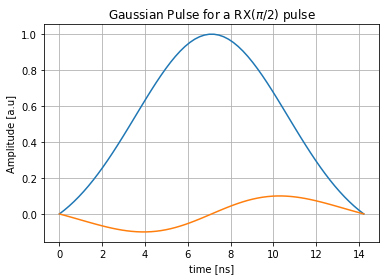

In [10]:
n = 64 # Duration in number of samples
tau = n*dt # duration in seconds
sigma = tau/4 # Parameter of the Gaussian Pulse
time = np.linspace(0,tau,n) 
Gauss = lambda t: np.exp(-0.5*((t - tau/2)/sigma)**2) # Gaussian Pulse
Gauss_trunc = lambda t: (Gauss(t) - Gauss(0))/(1 - Gauss(0)) # Truncate the Gaussian Pulse and start from zero
Samples = Gauss_trunc(time) # Samples for the gate
DGauss = lambda t: -((t - tau/2)/sigma**2)*(Gauss_trunc(t))  # Derivative of the Gaussian Pulse
DSamples = DGauss(time)/max(DGauss(time)) #Normalizing the DRAG pulse

fig, ax = plt.subplots()
ax.plot(time*1e9, Samples)
ax.plot(time*1e9, -DSamples*0.1)
ax.set_ylabel("Amplitude [a.u]")
ax.set_xlabel("time [ns]")
ax.grid()
ax.set_title(r"DRAG pulse for a RX($\pi$/2) gate")

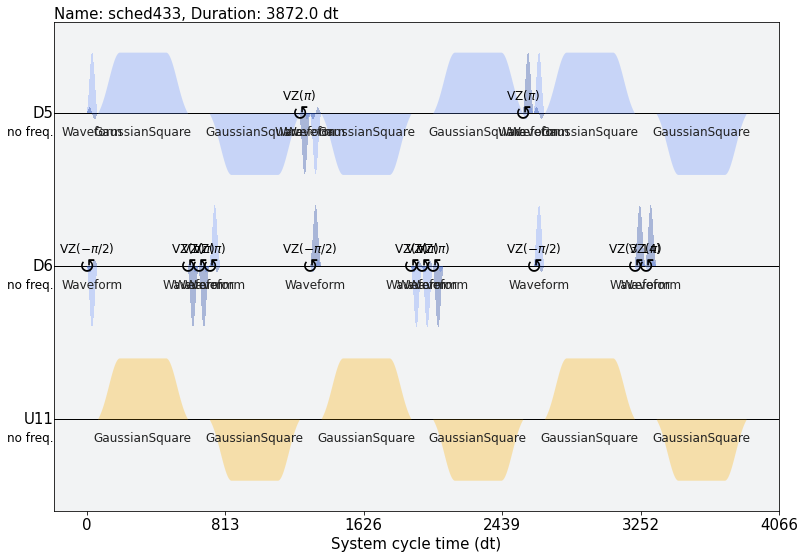

In [48]:
DRAG = lambda amp, beta: amp*Samples + 1j*beta*DSamples

def x_gate(amp, beta, qubit=0):
    schedule = pulse.Schedule()
    schedule |= pulse.ShiftPhase(-np.pi,DriveChannel(qubit)) 
    schedule |= pulse.Play(pulse.Waveform(DRAG(amp, beta)),DriveChannel(qubit))
    schedule |= pulse.ShiftPhase(-np.pi,DriveChannel(qubit)) << schedule.duration
    schedule |= pulse.Play(pulse.Waveform(-DRAG(amp, beta)),DriveChannel(qubit)) << schedule.duration
    return schedule
    
def y_gate(amp, beta, qubit=0):
    schedule = pulse.Schedule()
    schedule |= pulse.ShiftPhase(-np.pi/2,DriveChannel(qubit))
    schedule |= pulse.Play(pulse.Waveform(DRAG(amp, beta)),DriveChannel(qubit))
    schedule |= pulse.ShiftPhase(-np.pi,DriveChannel(qubit)) << schedule.duration 
    schedule |= pulse.Play(pulse.Waveform(-DRAG(amp, beta)),DriveChannel(qubit)) << schedule.duration
    schedule |= pulse.ShiftPhase(-np.pi/2,DriveChannel(qubit)) << schedule.duration
    return schedule

def h_gate(amp, beta, qubit=0):
    schedule = pulse.Schedule()
    schedule |= qk.pulse.ShiftPhase(-np.pi, DriveChannel(qubit)) << int(schedule.duration)
    schedule |= qk.pulse.Play(pulse.Waveform(1j*DRAG(amp, beta)),DriveChannel(qubit)) << int(schedule.duration) 
    return schedule

### Two-qubit calibration
After, being defined the sequence for one qubit gates, we define the two qubit gate calibration, the following code is customize for the CNOT gate between qubits 5 and 6 of the Casablanca device, because, the open-science prize specify that the improvement should be given for those qubits.

In [ ]:
def cx_gate(cr_amp, ampt_t, amp, beta, qubits, nCR=528, sigCR=64):
    schedule = pulse.Schedule()
    schedule += pulse.ShiftPhase(np.pi/2, DriveChannel(6)) 
    schedule += pulse.ShiftPhase(np.pi/2, ControlChannel(10))
    schedule += pulse.Play(pulse.Waveform(DRAG(amp[5], beta[5])),DriveChannel(5)) 
    schedule += pulse.Play(pulse.Waveform(1j*DRAG(amp[6], beta[6])),DriveChannel(6))
    duration = schedule.duration
    schedule += pulse.Play(pulse.GaussianSquare(duration=nCR,amp=ampt_t, sigma=sigCR, width=nCR-4*sigCR),DriveChannel(5))
    schedule += pulse.Play(pulse.GaussianSquare(duration=nCR,amp=cr_amp, sigma=sigCR, width=nCR-4*sigCR),ControlChannel(11)) << duration
    schedule |= x_gate(amp[6], beta[6], 6) << schedule.duration
    duration = schedule.duration
    schedule |= pulse.Play(pulse.GaussianSquare(duration=nCR, amp=-ampt_t, sigma=sigCR, width=nCR-4*sigCR),DriveChannel(5)) << duration
    schedule |= pulse.Play(pulse.GaussianSquare(duration=nCR, amp=-cr_amp, sigma=sigCR, width=nCR-4*sigCR),ControlChannel(11)) << duration
    return schedule


def swap_gate(cr_amp, amp_t, amps, betas, nCR=528, sigCR=64):
    CX = cx_gate(cr_amp, amp_t,amps,betas,[6,5])
    schedule = CX
    schedule += h_gate(amps[5],betas[5],qubit=5)
    schedule += h_gate(amps[6],betas[6],qubit=6)
    schedule += CX
    schedule += h_gate(amps[5],betas[5],qubit=5)
    schedule += h_gate(amps[6],betas[6],qubit=6)
    schedule += CX
    return schedule

amps = {5:0.1,6:0.1}
betas = {5:0.01,6:0.01}
schedule = swap_gate(0.1, 0.1, amps, betas)
schedule.draw()


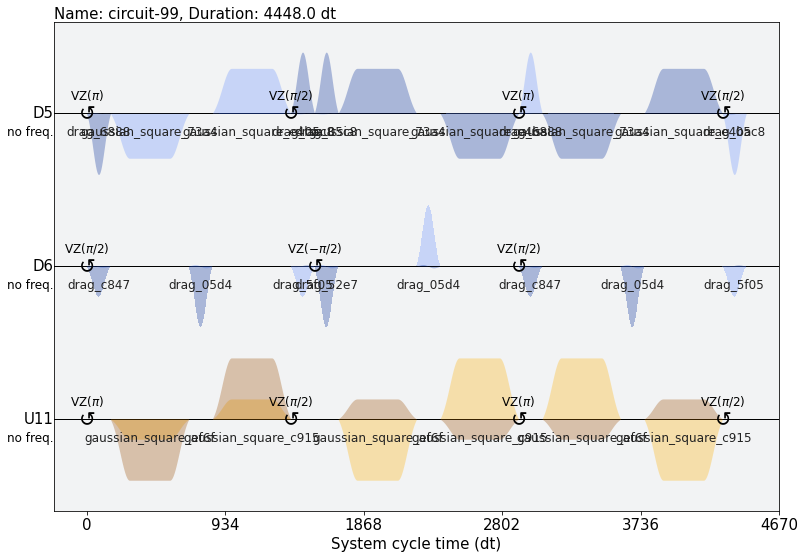

In [33]:
swap = qk.QuantumCircuit(7)
swap.swap(5,6)
swapT = qk.transpile(swap, backend)
sched = qk.schedule(swapT, backend)
sched.draw()

### Random-Benchmarking sequence Transformation
Before continuing, we need a way to transform a quantum circuit into pulses. From a set of Clifford gates in a circuit, we use the following set of functions to tranform them to pulses 

In [13]:
def transfor_to_gates(Circuits, opt, amps, betas, cr_amp, t_amp, qubits):
    """
    From a circuit with Clifford gates, we transform it to a set of DRAG pulses.

    Parameters
    ----------
    Circuits : QuantumCircuits
        Set of Clifford gates for the calibration.
    opt : int
        Calibration process option 0:Gaussian pulse 1:Derivative of the Gaussian 2:Cross Resonance Pulse 
        3:Rotary echoes on the target.
    amps : list
        Set of amplitudes for the Gaussian puslse.
    betas : list
        Set of amplitudes for the derivative of the Gaussian Pulse.
    cr_amp : float
        Amplitude of the cross-resonance pulse.
    t_amp : float
        Rotay echoe amplitude pulse for the target qubit (Sundaresan 2020).
    qubits : list
        List of qubits involve in the calibration.

    Returns
    -------
    scheduleT : pulse.Schedule
        Pulse representation of the Set of Circuits.

    """
    for circuit in Circuits:
        scheduleT = pulse.Schedule()
        schedule = pulse.Schedule()
        for gate in circuit:
            if opt in [0,1]: #Two options, one if we want to calibrate DRAG pulses opt 0 and 1
                qubit = qubits
                amp = amps
                drag = drags
            else: #and two if we want to calibrate CNOT gates opt 2 and 3
                qubit = gate[1][0].index
                amp = amps[qubit]
                drag = drags[qubit]
            if gate[0].name == 'x':
                schedule += x_gate(amp, drag, qubit)
            elif gate[0].name == 'y':
                schedule += y_gate(amp, drag, qubit)
            elif gate[0].name == 'h':
                schedule += h_gate(amp, drag, qubit)
            elif gate[0].name == "cx":
                scheduleT += schedule
                schedule = pulse.Schedule()
                cx = backend.defaults().instruction_schedule_map.get('cx',qubits = qubits)
                schedule |= cx_gate(cx, cr_amp, t_amp) << schedule.duration
                scheduleT += schedule
                schedule = pulse.Schedule()
            elif gate[0].name == 's':
                schedule += pulse.ShiftPhase(-np.pi/2, DriveChannel(qubit))
            elif gate[0].name == 'sdg':
                schedule += pulse.ShiftPhase(np.pi/2,DriveChannel(qubit))
            elif gate[0].name == 'z':
                schedule += pulse.ShiftPhase(-np.pi,DriveChannel(qubit))
        scheduleT += schedule
    return scheduleT

def gates_to_circuit(amps, betas, Circuits, qubits, opt, cr_amp=0, t_amp=0):
    schedules = []
    if opt in [0,1]: # Calibration of the DRAG pulses
        scheduleT = pulse.Schedule()
        for n, qubit in enumerate(qubits):
            amp = amps[n]
            beta = betas[n]
            scheduleT += transfor_to_gates(Circuits, opt, amp, beta, cr_amp, t_amp, qubit)
    else: # Calibration of CR and rotary Echoes
        scheduleT = transfor_to_gates(Circuits, opt, amps, betas, cr_amp, t_amp, qubits)
    scheduleT |= measure(qubits) << scheduleT.duration
    schedules.append(scheduleT)
    return schedules

def measure(qubits):
    sched= pulse.Schedule()
    channels = []
    for qubit in qubits:
        channels.append(MeasureChannel(qubit))
        channels.append(AcquireChannel(qubit))
    schedule = inst_sched_map.get("measure", qubits=range(backend.configuration().num_qubits))
    for inst in schedule.instructions: # Just to select the channels of the qubits involved
        if inst[1].channel in channels:
            sched |= inst[1] << inst[0]
    return sched

### Schedule execution and result extraction


In [ ]:
def preparing(amps, Circuits, qubits, betas=[0,0], opt=0, qubit=0, cr_amp=0, t_amp=0):
    """
    opt:0,1,2,3 
    0:drag Gaussina
    1:drag beta
    2: CX CR amplitude
    3: CX target rotary echoes amplitude
    """
    schedules = []
    if opt == 0:
        for i in range(len(xs[0])):
            schedules += gates_to_circuit([amps[j][i] for j in range(len(xs))], betas, Circuits, qubits, opt)
    elif opt == 1:
        for i in range(len(betas[0])):
            schedules += gates_to_circuit(amps , [betas[j][i] for j in range(len(betas))], Circuits, qubits, opt)
    elif opt == 2:
        for i in cr_amp:
            schedules += gates_to_circuit(amps , betas, Circuits, qubits, opt, cr_amp=i, t_amp=t_amp)
    elif opt == 3:
        for i in t_amp:
            schedules += gates_to_circuit(amps , betas, Circuits, qubits, opt, cr_amp=cr_amp, t_amp=i)
    else:
        Warning(f"Error opt {opt} is not a valid opt")        
    # Default  calibration error
    cir = qk.transpile(Circuits[0], backend, optimization_level=0)
    default = qk.schedule(cir, backend)
    schedules.append(default)
    return schedules
    
def Extract_T(result, qubits, exp, rep, ini=0):
    results = []
    for q in sorted(qubits):
        res_exp = [] 
        for i in range(exp*rep):
            counts = result.get_counts(i)    
            res_exp.append(0)
            for key in counts.keys():
                name = key[-(q+1)]
                if name == '0':
                    res_exp[i] += counts[key]
        res_exp = np.array(res_exp).reshape(exp,rep)
        results.append(res_exp)
    return results